In [16]:
import numpy as np
import matplotlib.pyplot as plt
import fenics as fe

from scipy.sparse import csr_matrix
from scipy.sparse.linalg import splu

from petsc4py import PETSc
from slepc4py import SLEPc

# my own (keep commented out for repro)
from statfenics.utils import dolfin_to_csr
from statfenics.covariance import sq_exp_spectral_density

def boundary(x, on_boundary):
    return on_boundary

In [17]:
mesh = fe.RectangleMesh(
    fe.Point(0, 0), fe.Point(1, 1), 128, 128)
V = fe.VectorFunctionSpace(mesh, "CG", 2)
element = fe.VectorElement("P", mesh.ufl_cell(), 2)

u_dofs = V.sub(0).dofmap().dofs()
v_dofs = V.sub(1).dofmap().dofs()

In [18]:
k = 32
bc = fe.DirichletBC(V, fe.Constant((0, 0)), boundary)

u1, u2 = fe.TrialFunctions(V)
q1, q2 = fe.TestFunctions(V)

a = (fe.inner(fe.grad(u1), fe.grad(q1)) * fe.dx)
A = fe.PETScMatrix()
fe.assemble(a, tensor=A)

M = fe.PETScMatrix()
fe.assemble(
    fe.inner(u1, q1) * fe.dx + fe.inner(u2, q2) * fe.dx, 
    tensor=M)

# sets BC rows of A to identity and sets rows of M to zeros
bc.apply(A)
bc.zero(M)

M = M.mat()
A = A.mat()

# solver inspired by: cmaurini
# https://gist.github.com/cmaurini/6dea21fc01c6a07caeb96ff9c86dc81e
E = SLEPc.EPS()
E.create()
E.setOperators(A)
E.setDimensions(nev=k, ncv=2*k)
E.setWhichEigenpairs(E.Which.TARGET_MAGNITUDE)
E.setTarget(0)
E.setTolerances(1e-12, 100_000)
S = E.getST()
S.setType("sinvert")
E.solve()

# check that things have converged
print(f"Eigenvalues converged: {E.getConverged()}")

# and set up objects for storage
vr, wr = A.getVecs()
vi, wi = A.getVecs()

laplace_eigenvals = np.zeros((k, ))
eigenvecs = np.zeros((vr.array_r.shape[0], k))
errors = np.zeros((k, ))

for i in range(k):
    laplace_eigenvals[i] = np.real(E.getEigenpair(i, vr, vi))
    eigenvecs[:, i] = vr.array_r
    errors[i] = E.computeError(i)

plt.plot(laplace_eigenvals, ".")
plt.show()

# np.testing.assert_allclose(errors, 0, atol=1e-12)

Error: error code 71

[5.01763259e-01 9.20663672e-01 1.73879275e-01 8.13187250e-01
 5.54526974e-04 9.89380747e-01 6.17372217e-01 3.63765398e-01
 4.96432969e-01 5.48599640e-01 3.29606267e-01 6.38345447e-01
 8.40450387e-01 2.36616209e-02 8.28227251e-01 3.07354148e-01
 9.15424238e-01 1.37670534e-01 4.68996043e-01 4.32403211e-03
 4.10528870e-01 4.58405352e-01 1.06891656e-02 9.90878118e-01
 4.65570826e-01 5.97116456e-01 8.24626048e-01 9.13739312e-02
 1.10914261e-01 8.52932279e-01 5.22679818e-01 9.47629777e-01]


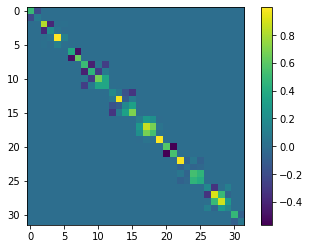

In [14]:
print((eigenvecs[v_dofs, :].T @ eigenvecs[v_dofs, :]).diagonal())

im = plt.imshow(eigenvecs[u_dofs, :].T @ eigenvecs[u_dofs, :])
plt.colorbar(im)
plt.show()